In [1]:
from visualizer import draw_dot
from head2grad import Value

In [2]:
v1 = Value(1)
v2 = Value(2)
v3 = v1 + v2

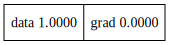

In [3]:
draw_dot(v1)

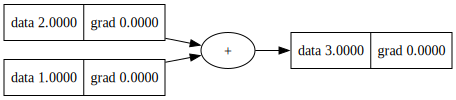

In [4]:
draw_dot(v3)